### TMA4320 - Project 2: Physics


# 0.0 Motivation

In [3]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from tempfile import TemporaryFile


# To show figures in the notebook
%matplotlib inline

# Make the figures more readable
newparams = {'figure.figsize': (18, 9), 'axes.grid': False,
             'lines.linewidth': 2,
             'font.size': 25, 'mathtext.fontset': 'stix',
             'font.family': 'STIXGeneral'}
# figure.figsize sets the size of the figure (values are in inches)
# axes.grid, set to False means that there is no grid
# lines.linewidth sets the thickness of the lines in the plot
# font.size sets the size of the text (ticks, title, xlabel, etc.)
# mathtext.fontset sets the font of the text of the type r'$tekst$' (math text)
# font.family sets the font of ordinary text (ticks, title, xlabel, etc.)

# There are several other parameters you can change, and you can look them up in the documentation 
# for matplotlib if you need to change any. 

plt.rcParams.update(newparams) # Updates the parameter set above. 

In [4]:
# Parameters
sigma_0 = 1000 # kg/m^2
sigma = 500 # kg/m^2
R = 10 # m, Radius
A_s = 0.5*np.pi*(R**2) # Cross-section of boat
A_0 = (sigma*np.pi*(R**2))/(2*sigma_0)
g = 9.81 # m/s^2
h = (4*R)/(3*np.pi)
m_boat = A_s*sigma

In [5]:
def calculate_I_c(m_load, s_L):
    '''
    This function calculated the ships total rotational inertia of the ship and its load, at the
    relative position of the load affects the total rotational inertia.
    Input:
        m_load: float, the mass of the load [kg]
        s_L:    float, the loads distance from the metacenter [m]
    Output:
        I_c:    float, the ships total rotational inertia [kg/m²]
    '''
    I_boat = 0.5*m_boat*(R**2)*(1-(32/(9*(np.pi**2)))) # Rotational inertia from the ship about C

    r_load = np.sqrt( h**2 + s_L**2 ) # Distance from ship's CM to load's CM
    I_load = m_load*r_load**2   # Rotational inertia from the load about C 
    
    I_c = I_load + I_boat # Use the superposition property of rotational inertias (Steiner's Thm).
    return I_c

In [6]:
def calculate_beta(rhs_constant, x0, tol=1.e-8, max_iter=50):
    ''' Given a right hand side and left hand side of a function and its derivatives, calculates the beta value of the function.
    
    Solve f(x)=0 by Newtons method, 
    
        The output of each iteration is printed
        Input:
        f_lhs: left hand side of function
        df_lhs: left hand side of derivative of function
        f_rhs: right hand side of function
        df_rhs: right hand side of derivative of function
        x0:  Initial values
        tol: The tolerance
      Output:
        The root and the number of iterations
    '''

    f = lambda beta: beta - np.sin(beta) - rhs_constant
    df = lambda beta: 1 - np.cos(beta)


    x = x0
    for k in range(max_iter):
        fx = f(x)
        if abs(fx) < tol:           # Accept the solution 
            break 
        x = x - fx/df(x)            # Newton-iteration
    return x

In [7]:
def print_beta():
    f_lhs = lambda beta: beta-np.sin(beta)
    df_lhs = lambda beta: 1 - np.cos(beta)

    f_rhs = lambda beta : np.pi * sigma/sigma_0
    df_rhs = 0

    beta = calculate_beta(np.pi*sigma/sigma_0,5)
    print("Beta = ",round(np.degrees(beta), 2),"degrees")
print_beta()

Beta =  132.35 degrees


In [8]:
#Define the global variables for the equilibrium, as requested in 1b)
y_M_0 = lambda beta: R*np.cos(beta/2)
y_C_0 = lambda beta: y_M_0(beta) - 4*R/(3*np.pi)
y_B_0 = lambda beta: y_M_0(beta) - 4*R*(np.sin(beta/2))**3 /(3*(beta-np.sin(beta)))
y_D_0 = lambda beta: y_M_0(beta) - R

#Values as functions of delta y_C and theta. 
y_M = lambda beta, theta, delta_y_C : y_M_0(beta) + ((4*R)/(3*np.pi))*(np.cos(theta)-1) + delta_y_C
y_C = lambda beta,delta_y_c : y_C_0(beta) + delta_y_c
y_D = lambda beta, theta, delta_y_c : y_D_0(beta) + ((4*R)/(3*np.pi))*(np.cos(theta)-1) + delta_y_c
y_B = lambda beta: y_B_0(beta)

#Note: beta is a global variable
gamma = lambda beta, theta, delta_y_c : 2*np.arccos(np.cos(beta/2)-(4/(3*np.pi))*(1-np.cos(theta))+delta_y_c/R)

water_area = lambda gamma_number: 0.5*(R**2)*(gamma_number - np.sin(gamma_number))

F_G = lambda m : -m*g
F_B = lambda A : A*sigma_0*g
friction = lambda k_f, omega, gamma_number : -k_f * R * gamma_number*omega

In [9]:
def euler_step(f, t, w, h_step):
    '''
    Tar inn en vektor-funksjon på formen w = [theta(t), omega(t)], med nåværende tid (t) og 
    tilstand (w), og regner ut ett Euler-steg.
    Inn:
        f: s-array, som beskriver et system av førsteordens diff-ligninger.
        t: float, nåvernde tid
        w: s-array, som beskriver systemet
        h_step: steglengde
    Ut:
        t_new: neste tidssteg (t+h)
        w_new: systemet etter ett beregnet tidssteg    
    '''
    
    w_new = w + h_step*f(t, w)
    return t+h, w_new

In [10]:
def solve_ODE(f, t_0, t_end, w_0, h_0, method, fixed_step = True, tol = 1e-6, max_iter = 1e5):
    '''
    Funksjon som løser differensial ligninger på en brukerdefinert måte.
    Inn:
        f: s-array, som beskriver et system av førsteordens diff-ligninger.
        t_0: float, starttid
        t_end: float, slittid
        w_0: s-array, som systemets startposisjon
        h_0: Dersom vi ønsker dynamisk steglengde vil dette være startsteglengden
            ellers blir dette den konstante steglengden
        tol: The tollerance if we wish to use adaptive step size
    Ut:
        t_num: array, tidsstegene
        w_num: s-array, de beregnede verdiene for theta of omega    
    '''
    t_num = np.array([t_0])
    w_num = w_0
    # Set the running values
    t_n = t_0
    w_i = w_0
    h_step = h_0
    

    if fixed_step:
        N = int( (t_end-t_0)/h_step + 1)
        t_num, h_step = np.linspace(t_0, t_end, N, retstep=True)  # Use linpace, as numpys documentation suggests this for
                                            # non-integer values, we also get the closed interval [t_0, t_end].
        # print(f't_num:\n {t_num}\n t_num minus one:\n {t_num[0:-1]}')        

        # This loop will iterate over all the t-values exept the last one. The reason for this is because the w corresponding
        # to the last t-value is calculated at the second last t-value, and so, both arrays have an equal lenght.
        for t_n in t_num[0:-1]: 
            w_i = method(f, t_n, w_i, h_step)[1] # Here we are only interrested in w, as the step size is fixed
            #print(f'w_num:\n {w_num}\n\n w_{i+1}:\n {w_n}\n\n\n\n ')
            w_num = np.concatenate(( w_num, w_i), axis=1)

    else: 
        current_iter = 0
        while t_n < t_end-1e-10: # take truncation error into account        
            if t_n + h_step > t_end:
                h_step = t_end-t_n
                
            # One step with the method:
            t_try, w_try, err_est, p = method(f, t_n, w_n, h_step)
            current_f_calls += 1
            
            if err_est <= tol:
                # Use the solution
                t_n = t_try
                w_n = w_try
                
                # Store the solutions
                t_num = np.append(t_num, t_n)           
                w_num = np.concatenate((w_num, np.array([w_n])))
                
            
            # Adjust the step size, start by defining facors
            P = 0.8 # Pessismist facor, normally between 0.5 and 0.95
            
            h_step = P*( (tol/err_est)**(1/(p+1)) )*h_step

            if current_iter >= max_iter:
                print('Maximum number of function calls are reached.')
                return t_num, w_num

    
    
    
    return t_num, w_num

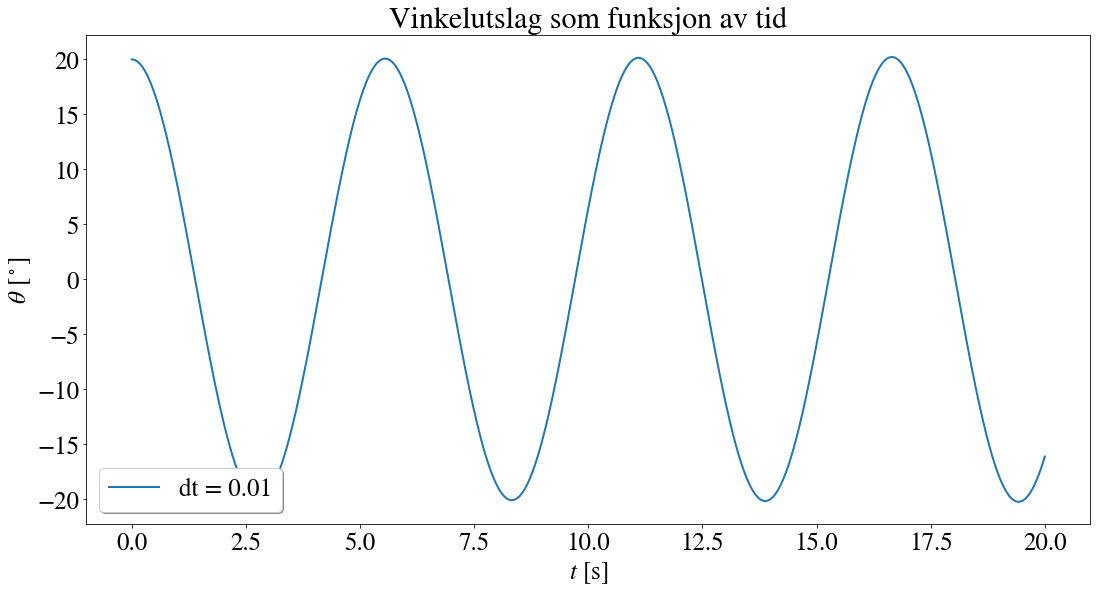

In [11]:
def test_euler():
    # f = lambda t, w: np.array([
    #     w[1],
    #     -(A_0 * sigma_0 * g * h)/calculate_I_c(0, 0) * np.sin( w[0] )
    #     ])
    
    # This function is equivalent
    def f(t, w):
        dw = np.array([
            w[1],
            -(A_0 * sigma_0 * g * h)/calculate_I_c(0, 0) * np.sin( w[0] )
        ])
        return dw

    # Define the inital condititons, time intervall, and step size
    theta_0 = np.array([np.radians(20)])
    omega_0 = np.array([0])
    w_0 = np.array([theta_0, omega_0]) # Combine all the initial conditions to the array w

    t_0 = 0
    t_end = 20

    h_step = 0.001  #The step size of our simulation

    # Calculate the angles and angle velocities in the given time intervall using the Euler method
    t_num, w_num = solve_ODE(f, t_0, t_end, w_0, h_step, euler_step)

    theta_num, omega_num = w_num[0:2]
    

    # Plot the angles vs time
    plt.plot(t_num, np.rad2deg(theta_num), label = "dt = 0.01")
    plt.title("Vinkelutslag som funksjon av tid")
    plt.xlabel('$t$ [s]')           
    plt.ylabel(r'$\theta$ [$^\circ$]')   
    # plt.ylim(-0.4,0.4)        
    plt.legend(loc=3, shadow = True)
    plt.show()

test_euler()

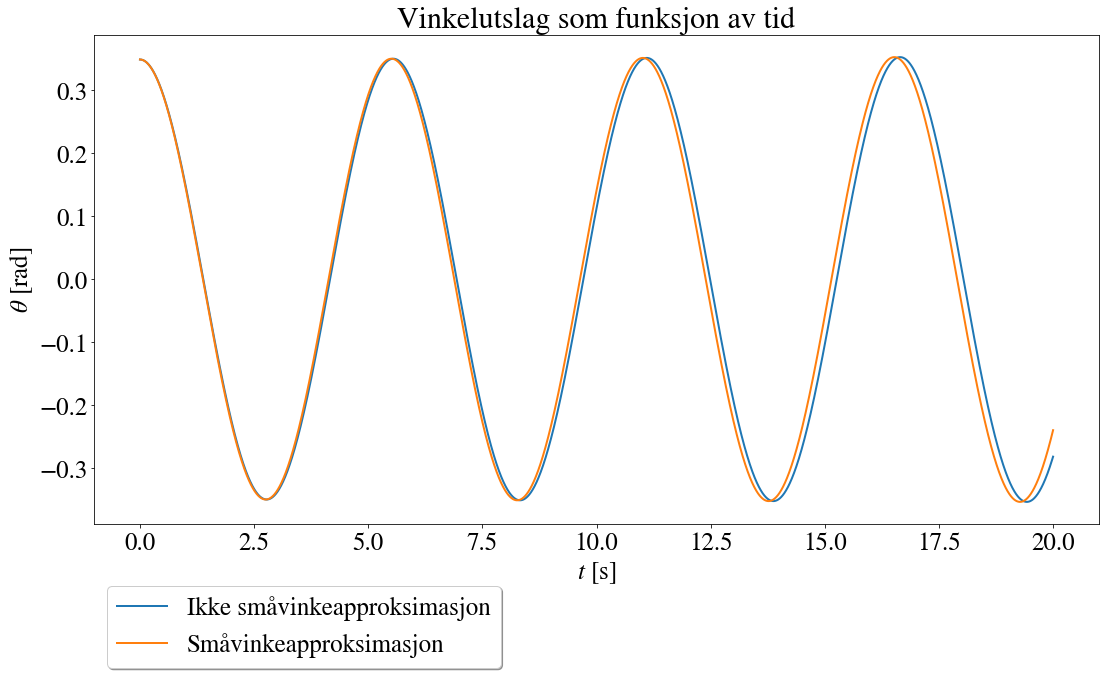

In [11]:
def angle_approx_comparison():
    # def f(t, w):
    #     const = (A_s*sigma * g * h)/calculate_I_c(0, 0)
    #     return np.array([w[1], -const*np.sin(w[0]),0,0,0,0,0,0])

    # def f_small_angle(t, w):
    #     const = (A_s*sigma * g * h)/calculate_I_c(0, 0)
    #     return np.array([w[1], -const*w[0],0,0,0,0,0,0])

    #######################################################################################
    #       Define the functions differential equations that we will be solving
    f = lambda t, w: np.array([
        w[1],
        -(A_s*sigma * g * h)/calculate_I_c(0, 0) * np.sin(w[0])
    ])
    f_small_angle = lambda t, w: np.array([
        w[1],
        -(A_s*sigma * g * h)/calculate_I_c(0, 0) * w[0]
    ])

    #######################################################################################
    #       Define the inital condititons, time intervall, and step size
    theta_0 = np.array([np.radians(20)])
    omega_0 = np.array([0])
    w_0 = np.array([theta_0, omega_0]) # Combine all the initial conditions to the array w

    t_0 = 0
    t_end = 20

    h_step = 0.001  #The step size of our simulation
    #######################################################################################
    #       Solve diff. eqn. by the given methods, and 
    t_num, w_num = solve_ODE(f, t_0, t_end, w_0, h_step, euler_step)
    t_num_small_angle_approx, w_num_small_angle_approx = solve_ODE(f_small_angle, t_0, t_end, w_0, h_step,euler_step)


    theta_num, omega_num = w_num[0:2]
    theta_num_small_angle_approx, omega_num_small_angle_approx = w_num_small_angle_approx[0:2]
    
    diff = theta_num_small_angle_approx - theta_num    


    plt.plot(t_num, theta_num, label = "Ikke småvinkeapproksimasjon")
    plt.plot(t_num_small_angle_approx, theta_num_small_angle_approx, label = "Småvinkeapproksimasjon")
    # plt.plot(t_num, diff, label = "Differanse")
    plt.title("Vinkelutslag som funksjon av tid")
    plt.xlabel('$t$ [s]')           
    plt.ylabel(r'$\theta$ [rad]')   
    # plt.ylim(-0.2,0.2)        
    plt.legend( 
        bbox_to_anchor=(0,-0.1),
        loc='upper left',
        shadow = True
        )
    plt.show()

angle_approx_comparison()

In [12]:
def rk4_step(f, t, w, h):
    '''
    Tar inn en vektor-funksjon på formen f(t, _w_) = _y'_ = _y_ + _g(x)_, med nåværende tid (t) og 
    tilstand (w), og regner ut ett Runge Kutta steg.
    Inn:
        f: s-array, som beskriver et system av førsteordens diff-ligninger.
        t: float, nåvernde tid
        w: s-array, som beskriver systemet
    Ut:
        t_new: neste tidssteg (t+h)
        w_new: systemet etter ett beregnet tidssteg    
    '''

    k_1 = f(t, w)
    k_2 = f(t + 0.5*h, w + h*k_1*0.5)
    k_3 = f(t + 0.5*h, w + h*k_2*0.5)
    k_4 = f(t + 1.0*h, w + h*k_3)

    w_new = w + h*(1/6) * (k_1 + 2*k_2 + 2*k_3 + k_4)
    t_new = t + h
    
    return t_new, w_new

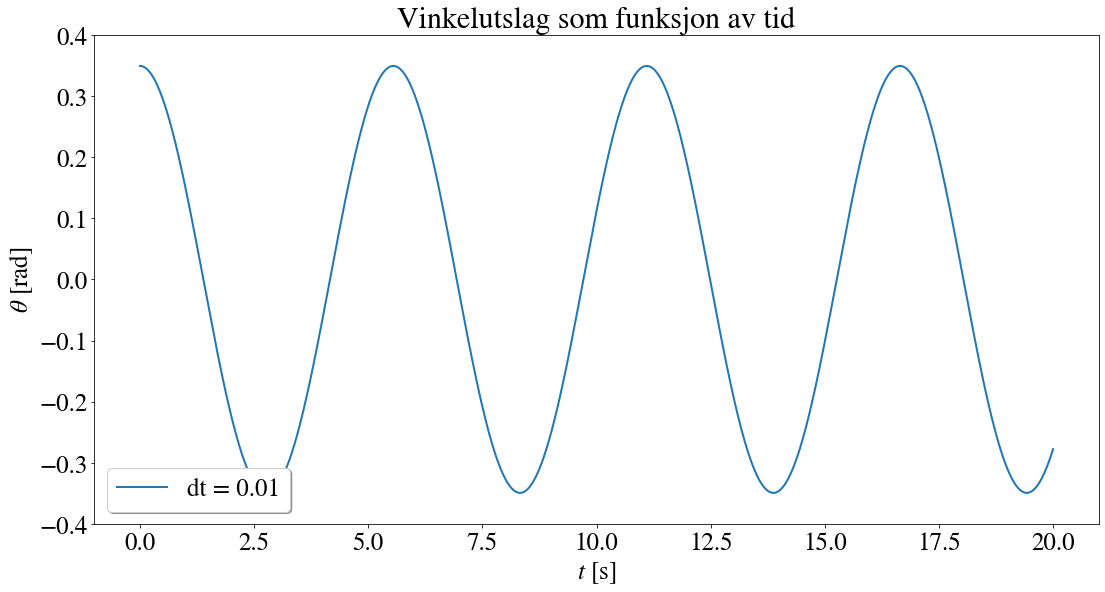

In [13]:
def test_runge_kutta():

    # def f(t, w):
    #     const = (A_s*sigma * g * h)/calculate_I_c(0, 0)
    #     return np.array([w[1], -const*np.sin(w[0]),0,0,0,0,0,0])
    
    #######################################################################################
    #       Define the functions differential equations that we will be solving
    f = lambda t, w: np.array([
        w[1],
        -(A_0 * sigma_0 * g * h)/calculate_I_c(0, 0) * np.sin( w[0] )
        ])


    #######################################################################################
    #       Define the inital condititons, time intervall, and step size
    theta_0 = np.array([np.radians(20)])
    omega_0 = np.array([0])
    w_0 = np.array([theta_0, omega_0]) # Combine all the initial conditions to the array w

    t_0 = 0
    t_end = 20

    h_step = 0.01  #The step size of our simulation
    #######################################################################################

    t_num_rk4, w_num_rk4 = solve_ODE(f, t_0, t_end, w_0, h_step, rk4_step)
    theta_num_rk4, omega_num_rk = w_num_rk4[0:2]


    plt.plot(t_num_rk4, theta_num_rk4, label = "dt = 0.01")
    plt.title("Vinkelutslag som funksjon av tid")
    plt.xlabel('$t$ [s]')           
    plt.ylabel(r'$\theta$ [rad]')   
    plt.ylim(-0.4,0.4)        
    plt.legend(loc=3, shadow = True)
    plt.show()
    
test_runge_kutta()

In [14]:
def anal_vs_num():
    #######################################################################################
    #       Define the functions differential equations that we will be solving
    def f_analytic(t, theta_0):
        return theta_0*np.cos( np.sqrt( (m_boat*g*h)/calculate_I_c(0, 0) )*t )
    
    # To be used in numerical solutions
    f_small_angle = lambda t, w: np.array([
        w[1],
        -(A_0 * sigma_0 * g * h)/calculate_I_c(0, 0) * w[0]
        ])
    f_not_small_angle = lambda t, w: np.array([
        w[1],
        -(A_0 * sigma_0 * g * h)/calculate_I_c(0, 0) * np.sin( w[0] )
        ])
    
    # def f_small_angle(t, w):
    #     const = (A_s*sigma * g * h)/calculate_I_c(0, 0)
    #     return np.array([w[1], -const*w[0],0,0,0,0,0,0])
    # def f_not_small_angle(t, w):
    #     const = (A_s*sigma * g * h)/calculate_I_c(0, 0)
    #     return np.array([w[1], -const*  np.sin(w[0]),0,0,0,0,0,0])


    # theta_0 = np.radians(0.01)
    # omega_0 = 0
    # w_0 = np.array([theta_0, omega_0,0,0,0,0,0,0])

    # t_0 = 0
    # t_end = 20


    #######################################################################################
    #       Define the inital condititons, time intervall, the array of step sizes, 
    #       and the analytic value at t=20s
    theta_0 = np.array([0.01])
    omega_0 = np.array([0])
    w_0 = np.array([
        theta_0, 
        omega_0
    ]) # Combine all the initial conditions to the array w

    t_0 = 0
    t_end = 20

    h_steps = 10**np.linspace(-4, -1, 30)


    #######################################################################################
    #       Find the values of different methods (including analytic) at t=20s
    #       using different step sizes
    f_analytic_t_20 = f_analytic(t_end, theta_0) # Analytic value at t=20s

    theta_t20_arr_euler = np.array([])
    theta_t20_arr_rk4 = np.array([])

    # Iterate through all the desired step sizes, and store them
    for h_step in h_steps:
        theta_euler    =   solve_ODE(f_small_angle, t_0, t_end, w_0, h_step, euler_step)[1][0] #[1]: w, [0]: theta
        theta_rk4      =   solve_ODE(f_small_angle, t_0, t_end, w_0, h_step, rk4_step)[1][0]
        
        # t_euler, theta_euler = solve_ODE(f_small_angle, t_0, t_end, w_0, h_step, euler_step) #[1]: w, [0]: theta)
        # t_rk4, theta_rk4 = solve_ODE(f_small_angle, t_0, t_end, w_0, h_step, euler_step) #[1]: w, [0]: theta)
        # print(f'last euler t: {t_euler[-1]}')
        # print(f'last rk4 t: {t_rk4[-1]}')

        # Store the angle at t=20s (the last angle)
        theta_t20_arr_euler =   np.append(theta_t20_arr_euler, theta_euler[-1])
        theta_t20_arr_rk4   =   np.append(theta_t20_arr_rk4 , theta_rk4[-1])


    difference_euler    = theta_t20_arr_euler   -   f_analytic_t_20
    difference_rk4      = theta_t20_arr_rk4     -   f_analytic_t_20
    # difference_rk4 = np.abs(difference_rk4)
    
    #######################################################################################
    #       Save the data to a file
    np.savez(
        'simulation_data/difference_at_t20',
        h_steps = h_steps,
        difference_euler = difference_euler,
        difference_rk4 = difference_rk4
        
        )
# anal_vs_num()

In [19]:
#######################################################################################
#       Plot the differences
def plot_difference():
    
    diff_data = np.load('simulation_data/difference_at_t20.npz')
    h_steps, difference_euler, difference_rk4 = diff_data['h_steps'], diff_data['difference_euler'], diff_data['difference_rk4']

    plt.yscale("log")
    plt.xscale("log")
    plt.plot(h_steps, np.zeros(len(h_steps)),linestyle='--') # Stiplet linje i 0
    plt.plot(h_steps, np.abs(difference_euler), label = "Euler")
    plt.plot(h_steps, np.abs(difference_rk4), label = "RK4")
    plt.plot(h_steps, np.abs(difference_rk4),'o', label = "Logaritmisk linspace")

    plt.title("Differansen mellom den analytiske og RK4 ved t = 20 s")
    plt.xlabel('$h$')           
    plt.ylabel(r'$\Delta\theta$ [rad]')   
    #plt.ylim(-0.2,0.2)        
    plt.legend(loc=1, shadow = True)
    plt.show()


    # plt.yscale("log")
    # plt.plot(h_steps, np.zeros(len(h_steps)),linestyle='--') # Stiplet linje i 0
    # plt.plot(h_steps, difference_euler, label = "Euler")
    # plt.plot(h_steps, difference_rk4, label = "RK4")

    # plt.title("Differansen mellom den analytiske og RK4 ved t = 20 s")
    # plt.xlabel('$h$')           
    # plt.ylabel(r'$\Delta\theta$ [rad]')

    # plt.legend(loc=2, shadow = True)
    # plt.show()

plot_difference()

FileNotFoundError: [Errno 2] No such file or directory: 'simulation_data/difference_at_t20.npz'

In [15]:
def check_capsizing(w_num):
    '''
    Checks if the boat is capsizing. 
    Input:
    w_num: array with all the physical properties of the boat
    output:
    w_num: Same array, but now updated values if the boat has capsized.
    
    '''
    beta = calculate_beta(np.pi*sigma/sigma_0, 5) # Guess 5 for initial beta

    theta_arr = w_num[0]
    y_arr = w_num[3]
    for i in range(len(theta_arr)-1):
        theta_n = theta_arr[i]
        delta_y_n= y_arr[i+1]-y_arr[i]
        delta_y_c_n = y_C(beta,delta_y_n)
        if theta_n > 0.5*(np.pi-gamma(beta,theta_n,delta_y_c_n,)): #Sjekk om båten kantrer
           
            theta_arr[i+1] = np.pi/2 * np.sign(theta_arr[i])
           
            for j in range(1,(len(w_num))):
                w_num[j][i+1]=0
            
    return w_num

In [16]:
def universal_func(w_start_vals, t_end_input, h_step_input, F_0, k_f, omega_w_input, m_boat_input, m_L_input):
    '''
    Universell funksjon som kan benyttes til å beregne bevegelsen til skipet for mange ulike tilfelle.
    Gjennom hva man skriver i funksjonens argument kan man bla. simulere påvikningen friksjon, bølger og last.
    Inn:
        w_start_vals: s-array, inneholder alle startverdier 
            w_start_vals = [theta_0, omega_0, x_C_0, y_C_0, v_x_0, v_y_0, s_L_0, v_L_0]
        t_end_input: float, sluttid til simulasjonen
        h_step_input: float, steglengde til simulasjonen
        F_0: float, amplitiden til den harmoniske funksjonen som beskriver vind/bølger
        k_f: float, friksjonskoeffesient
        omega_w_input: float, vinkelfrekvensen til den harmoniske funksjonen som beskriver vind/bølger
        m_boat_input: float, massen til båten
        m_L_input: float, massen til lasten
    Ut:
        t_num: array, tidsverdier
        w_num: array, w som inneholder alle beregnede verdier
    '''
    
    
    # Sector-angle in equilibrium
    beta_step = calculate_beta((np.pi*sigma*(R**2)+2*m_L)/(sigma_0*(R**2)), 5) # Guess 5 for initial beta
    m_tot = m_boat + m_L
    
    # Equating the moment of intertia
    I_C = calculate_I_c(0, 0)
    
    def f(t, w):  
        '''
        Funksjon som brukes til å regne ut endringen til systemet.
        Inn:
            t: float, tid
            w: s-array, beskriver diverse av systemets fysiske egenskaper
        Ut:
            dw: endringen i w i det neste tidssteget
        
        '''
        # Vertical displacement
        delta_y_C_step = w[3] - y_C_0(beta_step) 
        
        # Sector-angle
        gamma_step = 2*np.arccos(np.cos(beta_step/2) - (4/(3*np.pi))*(1-np.cos(w[0])) + delta_y_C_step/R)
       
        # Repressed water
        A_step = water_area(gamma_step)
        
        # Gravitation and bouancy
        F_G_step = F_G(m_boat)
        F_B_step = F_B(A_step)
        
        # Friction and wind/waves
        F_w_step = F_0*np.cos(t*omega_w)
        F_f_step = friction(k_f, w[1], gamma_step)
        
        # The components of the contact-force between the load and the ship
        F_L_x_step = m_L*g*np.cos(w[0])*np.sin(w[0])
        F_L_y_step = -m_L*g*(np.cos(w[0])**2)
 
        # Torque 
        tau_B_step = -F_B_step*h*np.sin(w[0])
        tau_f_step = F_f_step*(w[3] - (R*(np.cos(gamma_step/2)-1)))
        tau_w_step = F_w_step*w[3]
        tau_L_step = -m_L*g*np.cos(w[0])*w[6]
    
        # Equate valier for the derivative of the w-vector, and combining them in an array
        d_theta = w[1]
        d_omega = (1/I_C)*(tau_B_step + tau_f_step + tau_w_step + tau_L_step)
        d_x     = w[4]
        d_y     = w[5]
        d_v_x   = (1/m_tot)*(F_f_step + F_w_step + F_L_x_step)
        d_v_y   = (1/m_tot)*(F_G_step + F_B_step + F_L_y_step)
        d_s_L = w[7]
        d_v_L = g*np.sin(w[0])
        
        dw = np.array([
            d_theta,
            d_omega,
            d_x,
            d_y,   
            d_v_x,  
            d_v_y, 
            d_s_L,
            d_v_L
        ])
        
        return dw

    # Initsialverdier
    theta_0 = np.array([np.radians(w_start_vals[0])])
    omega_0 = np.array([w_start_vals[1]])
    x_C_0 = np.array([w_start_vals[2]])
    
    # Tenk ut en god løsning på dette. 
    initial_y_C = np.array([y_C_0(beta_step)])
    #initial_y_C = np.array([w_start_vals[3]])
    
    v_x_0 = np.array([w_start_vals[4]])
    v_y_0 = np.array([w_start_vals[5]])
    s_L_0 = np.array([w_start_vals[6]])
    v_L_0 = np.array([w_start_vals[7]])

    w_0 = np.array([
        theta_0, 
        omega_0, 
        x_C_0, 
        initial_y_C, 
        v_x_0, 
        v_y_0, 
        s_L_0, 
        v_L_0
    ])

    t_0 = 0
    t_num, w_num = solve_ODE(f, t_0, t_end_input, w_0, h_step_input, rk4_step)
    w_num = check_capsizing(w_num)
    return t_num, w_num

In [17]:
def plot_func(t_num_arr, values_2d_arr, label_arr, title_name, x_axis_name, y_axis_name):
    for i in range(len(values_2d_arr)):
        plt.plot(t_num_arr, values_2d_arr[i], label = label_arr[i])
    plt.title(title_name)
    plt.xlabel(x_axis_name)           
    plt.ylabel(y_axis_name)   
    # plt.ylim(-0.25,0.25)        
    plt.legend(loc=3, shadow = True)
    plt.show()

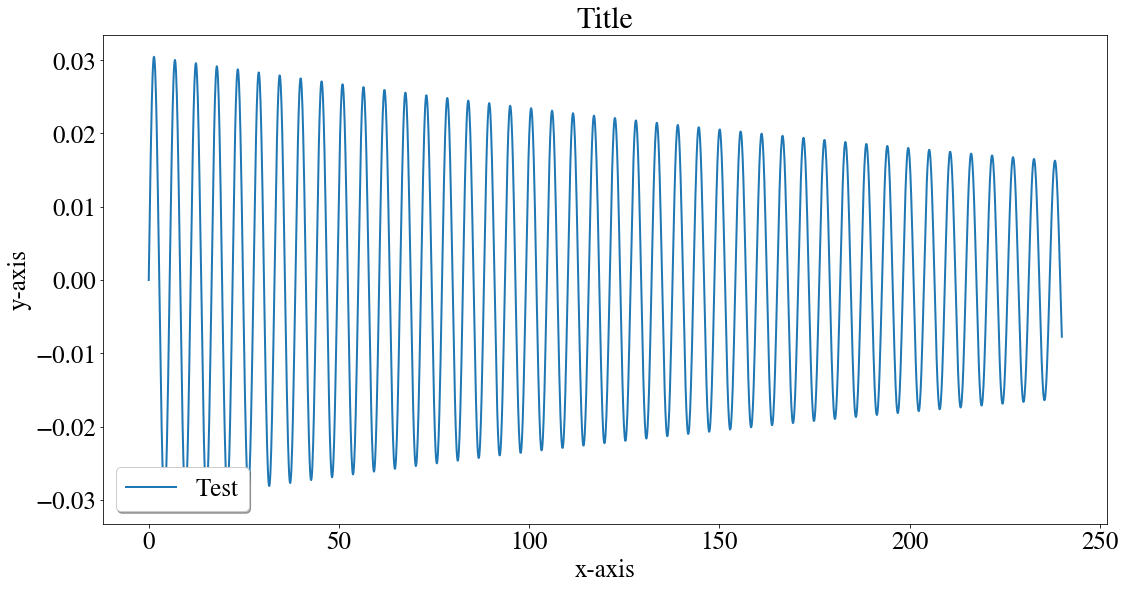

In [18]:
w_start_vals = [0, np.radians(2), 0, 0, 0, 0, 0, 0]

#F_0 = 0.625*m_boat*g
F_0 = 0
k_f = 100
t_end = 240
h_step = 0.1

omega_0 = np.sqrt((m_boat*g*h)/calculate_I_c(0, 0))
omega_w = 0.93*omega_0

m_boat = A_s*sigma
m_L = 0

t_num, w_num = universal_func(w_start_vals, t_end, h_step, F_0, k_f, omega_w, m_boat, m_L)

theta_num = w_num[0]
plot_func(t_num, [theta_num], ["Test"], "Title", "x-axis", "y-axis")

## 2b)

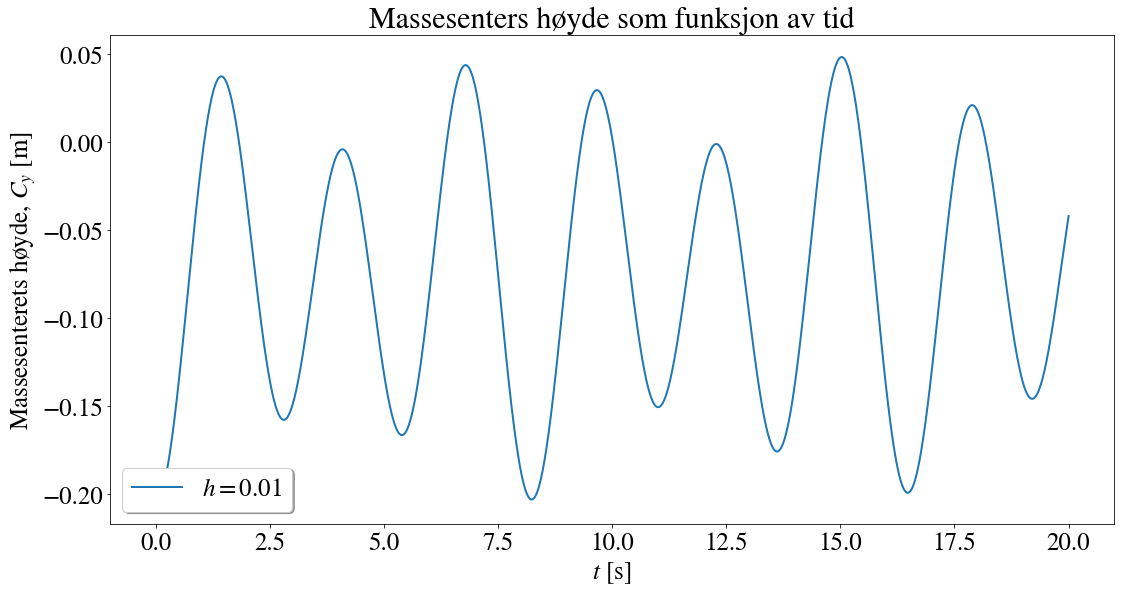

In [19]:
w_start_vals = [20, 0, 0, 0, 0, 0, 0, 0]

F_0 = 0
k_f = 0
t_end = 20
h_step = 0.01

omega_0 = np.sqrt((m_boat*g*h)/calculate_I_c(0, 0))
omega_w = 0.93*omega_0

m_boat = A_s*sigma
m_L = 0

t_num, w_num = universal_func(w_start_vals, t_end, h_step, F_0, k_f, omega_w, m_boat, m_L)

y_num = w_num[3]
plot_func(t_num, [y_num], [f"$h = 0.01$"], "Massesenters høyde som funksjon av tid", '$t$ [s]', r'Massesenterets høyde, $C_y$ [m]')

## 2d

## 2f

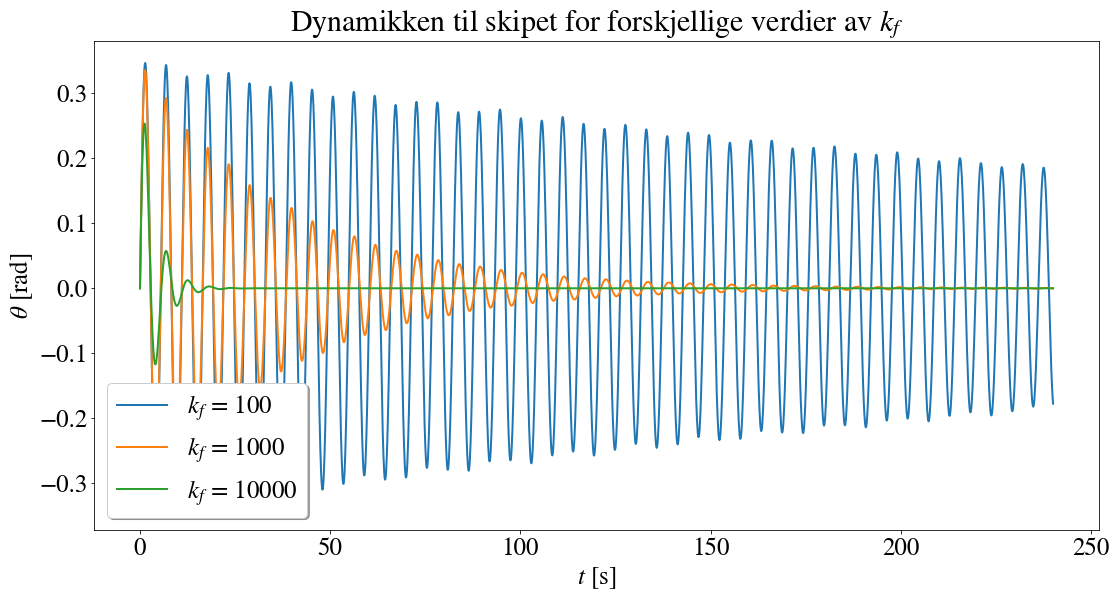

In [20]:
w_start_vals = [0, 0.4, 0, 0, 0, 0, 0, 0]

F_0 = 0
t_end = 240
h_step = 0.1

omega_0 = np.sqrt((m_boat*g*h)/calculate_I_c(0, 0))
omega_w = 0.93*omega_0

k_f_1 = 100
k_f_2 = 1000
k_f_3 = 10000

k_f_vals = [k_f_1, k_f_2, k_f_3]

m_boat = A_s*sigma
m_L = 0

t_vals = []
w_vals = []
theta_vals = []

for i in range(len(k_f_vals)):
    t_num_temp, w_num_temp = universal_func(w_start_vals, t_end, h_step, F_0, k_f_vals[i], omega_w, m_boat, m_L) 
    
    t_vals.append(t_num_temp)
    w_vals.append(w_num_temp)
    theta_vals.append(w_num_temp[0])
    
labels = []
for k_f_val in k_f_vals:
    labels.append(f"$k_f$ = {k_f_val}")
    
plot_func(t_vals[0], theta_vals, labels, f"Dynamikken til skipet for forskjellige verdier av $k_f$", "$t$ [s]", r"$\theta$ [rad]")

## 2g)

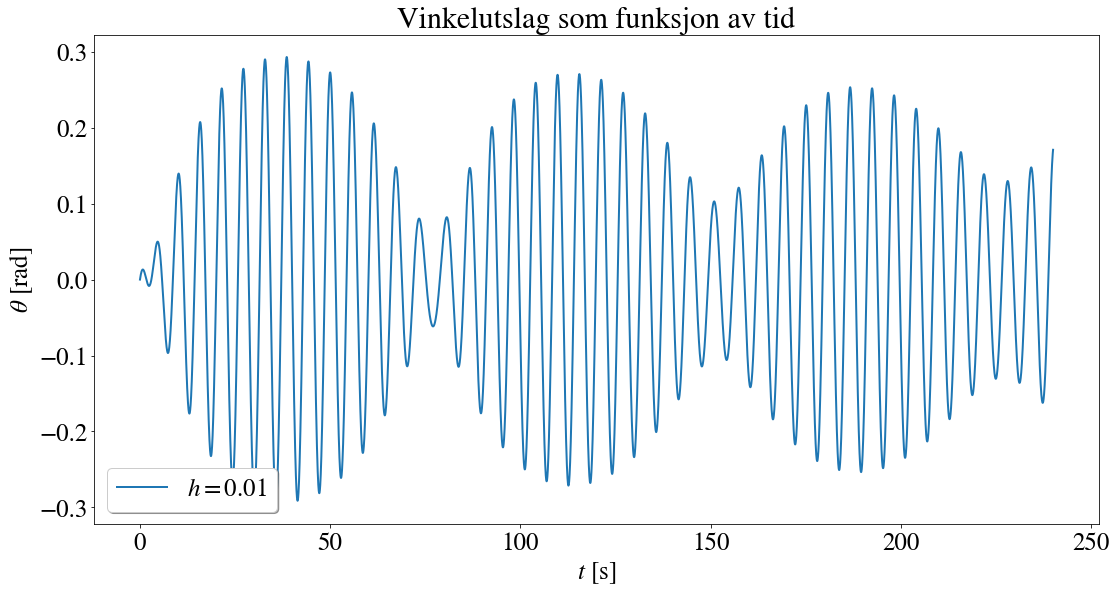

In [21]:
w_start_vals = [0, np.radians(2), 0, 0, 0, 0, 0, 0]

F_0 = F_0 = 0.625*m_boat*g
k_f = 100
t_end = 240
h_step = 0.01

omega_0 = np.sqrt((m_boat*g*h)/calculate_I_c(0, 0))
omega_w = 0.93*omega_0

m_boat = A_s*sigma
m_L = 0

t_num, w_num = universal_func(w_start_vals, t_end, h_step, F_0, k_f, omega_w, m_boat, m_L)

theta_num = w_num[0]
plot_func(t_num, [theta_num], [f"$h = 0.01$"], "Vinkelutslag som funksjon av tid", '$t$ [s]', r'$\theta$ [rad]')